In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [11]:
df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Time Series Analysis/Python - Time Series Forecasting/Time Series Analysis/CAPSTONE PROJECT - Airmiles/airmiles.csv',index_col='Date',parse_dates=True,date_format='%d/%m/%Y')
df.index = df.index.to_period('M')
df.head()

,airmiles
Date,
1996-01,30983174
1996-02,32147663
1996-03,38342975
1996-04,35969113
1996-05,36474391


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 113 entries, 1996-01 to 2005-05
Freq: M
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   airmiles  113 non-null    int64
dtypes: int64(1)
memory usage: 1.8 KB


# Initial EDA

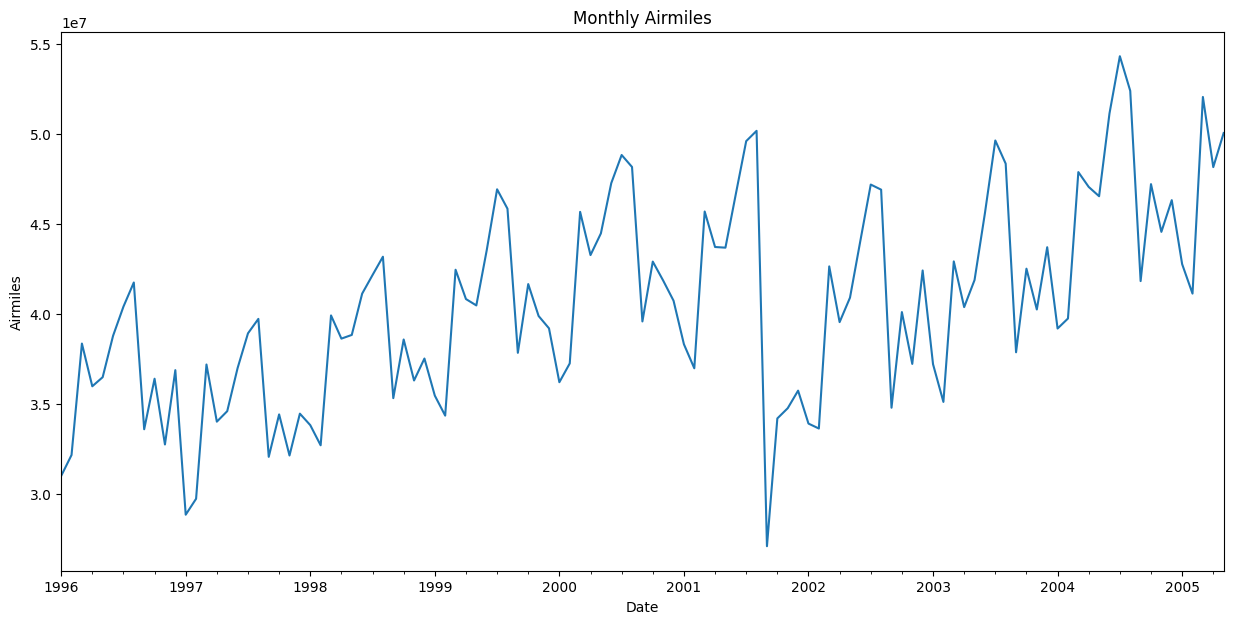

In [14]:
df['airmiles'].plot(figsize=(15,7))
plt.ylabel('Airmiles')
plt.title('Monthly Airmiles')
plt.show()

12 month Rolling Average Plot

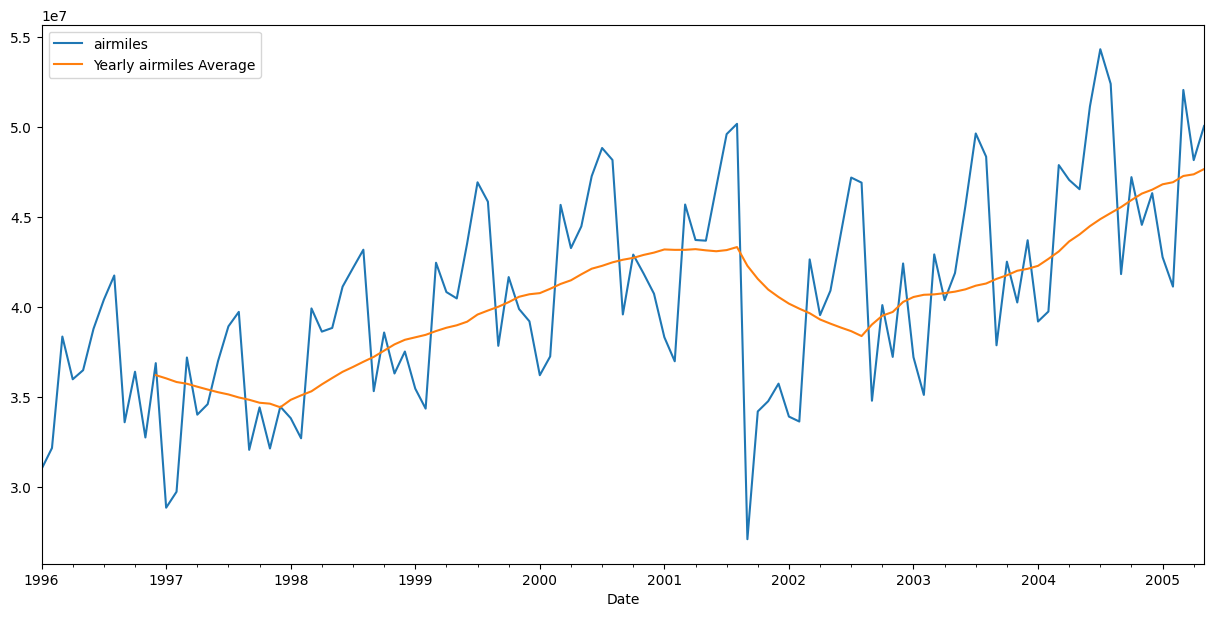

In [17]:
df['Yearly airmiles Average'] = df['airmiles'].rolling(window=12).mean()
df[['airmiles', 'Yearly airmiles Average']].plot(figsize=(15,7))
plt.show()

Let's find the month with the highest airmiles average.

In [20]:
df.resample('M').mean()['airmiles'].idxmax()

Period('2004-07', 'M')

Percentage change from month to month

In [21]:
df['Pct Change'] = df['airmiles'].pct_change()
df.head()

,airmiles,Yearly airmiles Average,Pct Change
Date,,,
1996-01,30983174,NaN,NaN
1996-02,32147663,NaN,0.037585
1996-03,38342975,NaN,0.192714
1996-04,35969113,NaN,-0.061911
1996-05,36474391,NaN,0.014048


Filter for dates where percentage change (+ or -) is greater than 10%

In [22]:
df[abs(df['Pct Change']) > 0.1]

,airmiles,Yearly airmiles Average,Pct Change
Date,,,
1996-03,38342975,NaN,0.192714
1996-09,33580773,NaN,-0.195448
1996-11,32734901,NaN,-0.100438
1996-12,36866146,3.619961e+07,0.126203
1997-01,28829794,3.602017e+07,-0.217987
1997-03,37179450,3.572051e+07,0.251186
1997-09,32047526,3.483009e+07,-0.193082
1998-03,39908269,3.530214e+07,0.220868
1998-09,35309230,3.721465e+07,-0.182119


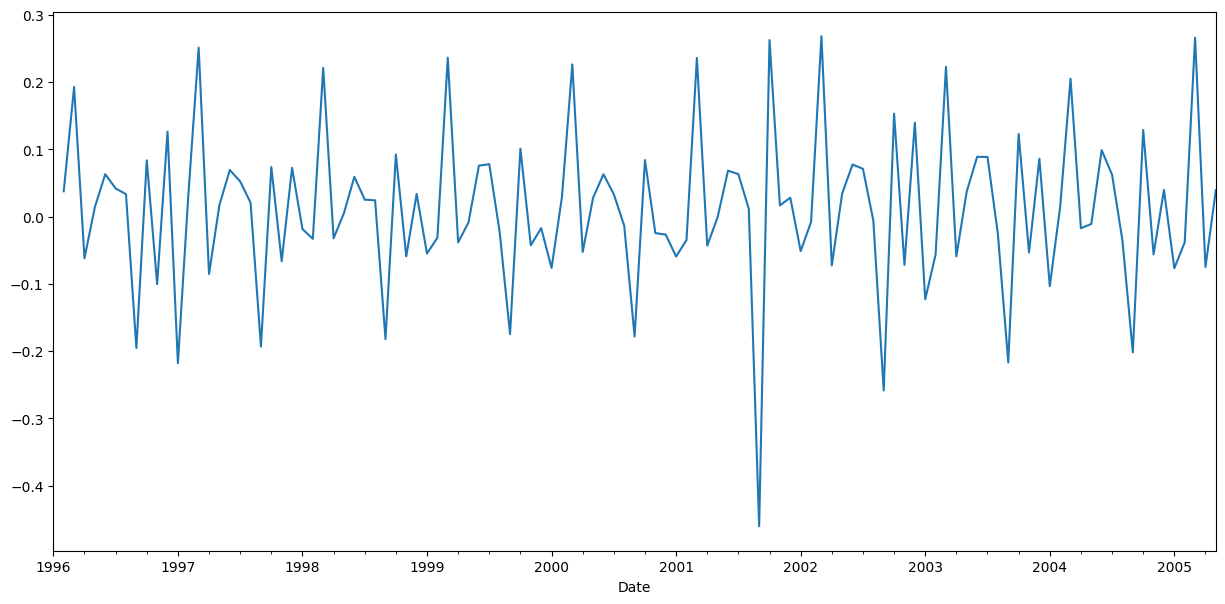

In [23]:
df['Pct Change'].plot(figsize=(15,7))
plt.show()

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 113 entries, 1996-01 to 2005-05
Freq: M
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   airmiles                 113 non-null    int64  
 1   Yearly airmiles Average  102 non-null    float64
 2   Pct Change               112 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 3.5 KB


In [25]:
df['Yearly airmiles Average'] = df['Yearly airmiles Average'].interpolate(limit_direction='backward')
df.isnull().sum()

,0
airmiles,0
Yearly airmiles Average,0
Pct Change,1


# Lagged Variables

In [26]:
df['airmiles Lag 1'] = df['airmiles'].shift(1)
df['airmiles Lag 2'] = df['airmiles'].shift(2)
df.head()

,airmiles,Yearly airmiles Average,Pct Change,airmiles Lag 1,airmiles Lag 2
Date,,,,,
1996-01,30983174,3.619961e+07,NaN,NaN,NaN
1996-02,32147663,3.619961e+07,0.037585,30983174.0,NaN
1996-03,38342975,3.619961e+07,0.192714,32147663.0,30983174.0
1996-04,35969113,3.619961e+07,-0.061911,38342975.0,32147663.0
1996-05,36474391,3.619961e+07,0.014048,35969113.0,38342975.0


# Airmiles Seasonality

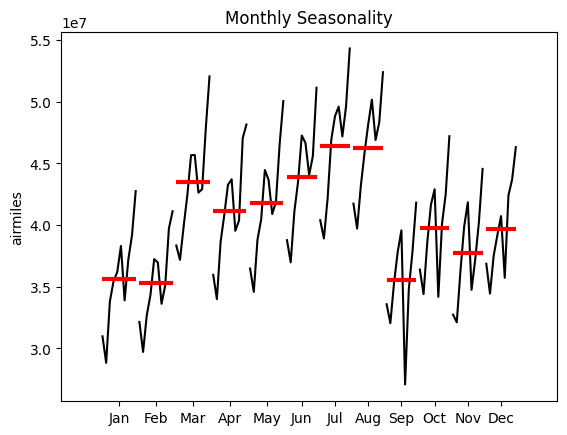

In [30]:
# Monthly Seasonality
month_plot(df['airmiles'].resample('M').mean())
plt.title('Monthly Seasonality')
plt.ylabel('airmiles')
plt.show()

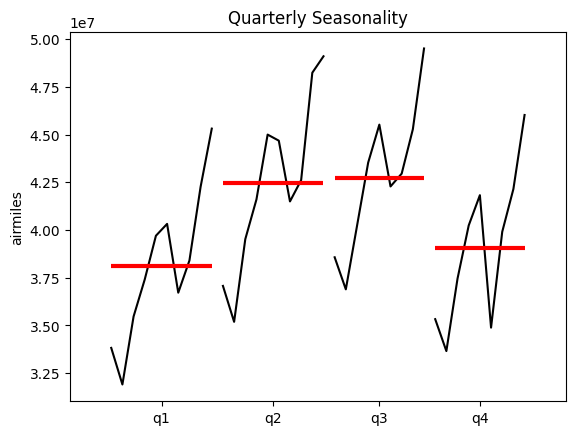

In [32]:
# Quarterly Seasonality

quarter_plot(df['airmiles'].resample('Q').mean())
plt.title('Quarterly Seasonality')
plt.ylabel('airmiles')
plt.show()

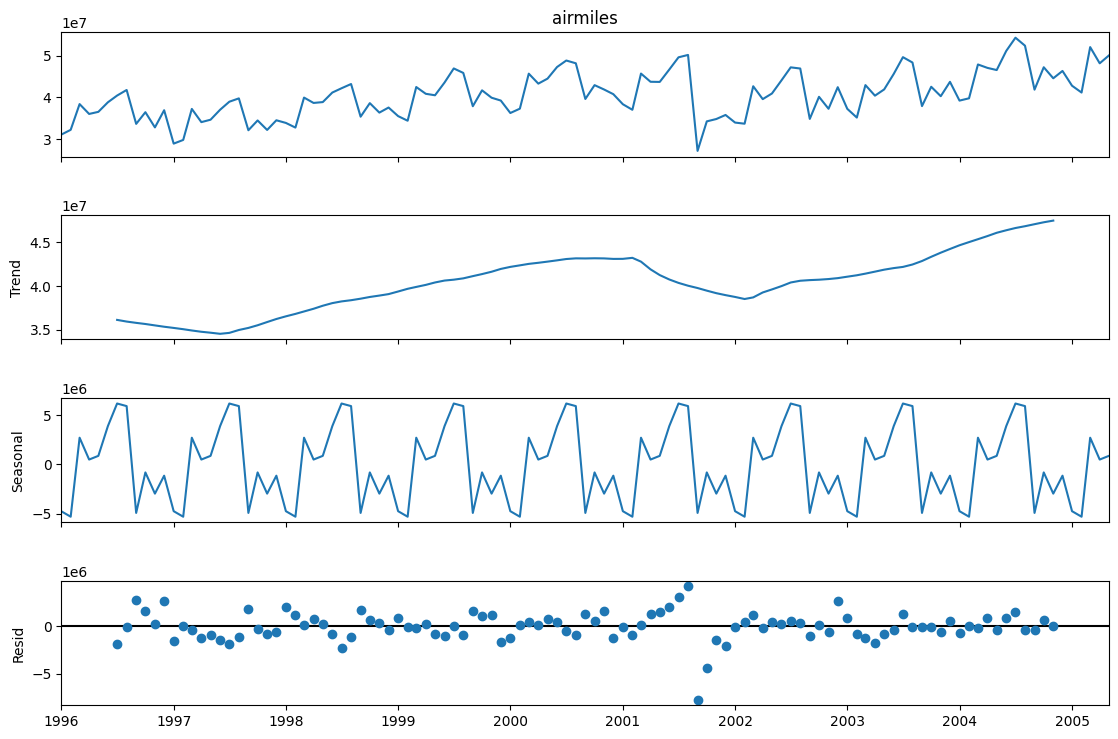

In [36]:
# Seasonal decomposition of 'airmiles'  (12 month period, model='additive')
df.index = df.index.to_timestamp()
result = seasonal_decompose(df['airmiles'], model='additive', period=12)
fig = result.plot()
fig.set_figheight(8)
fig.set_figwidth(12)
plt.show()

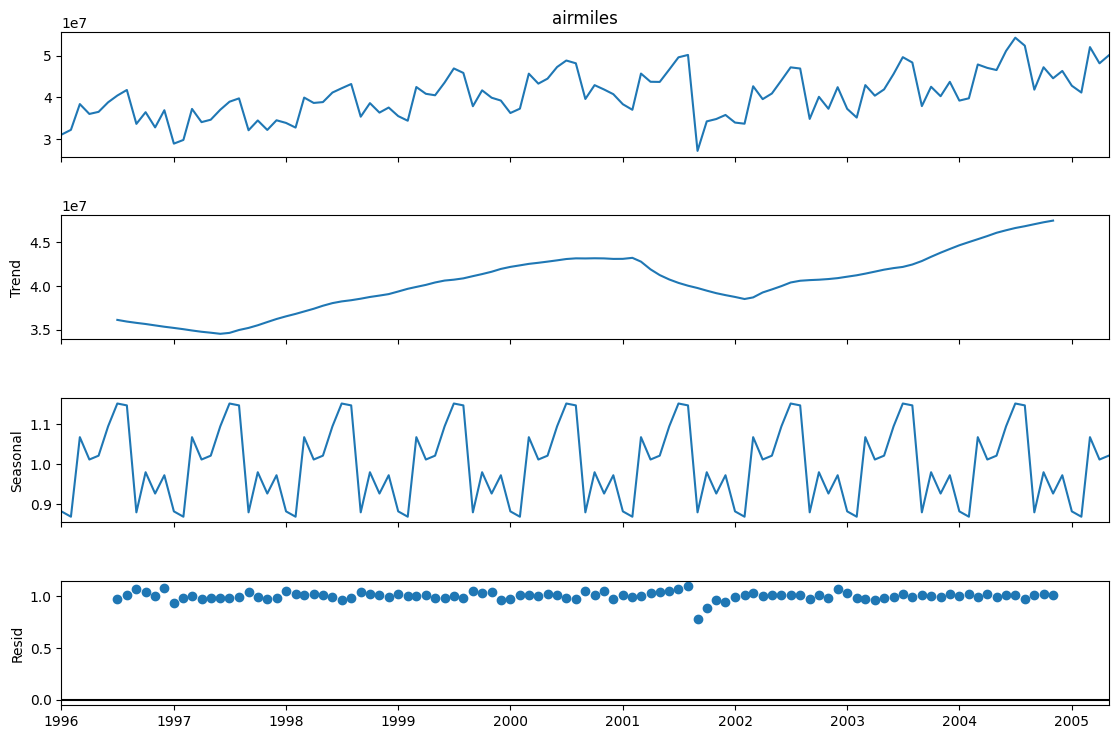

In [37]:
# Seasonal decomposition of 'airmiles' (12 month period, model='multiplicative')
result = seasonal_decompose(df['airmiles'], model='multiplicative', period=12)
fig = result.plot()
fig.set_figheight(8)
fig.set_figwidth(12)
plt.show()

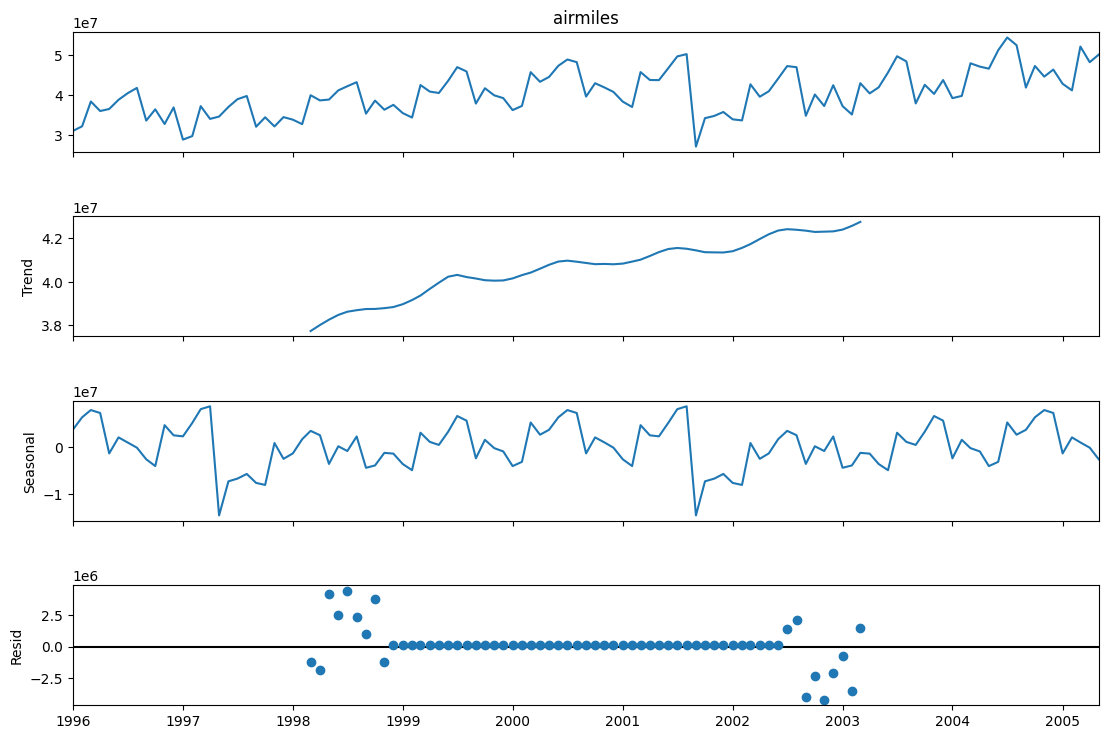

In [38]:
# Seasonal decomposition of 'airmiles'  (52 week period, model='additive')
result = seasonal_decompose(df['airmiles'], model='additive', period=52)
fig = result.plot()
fig.set_figheight(8)
fig.set_figwidth(12)
plt.show()

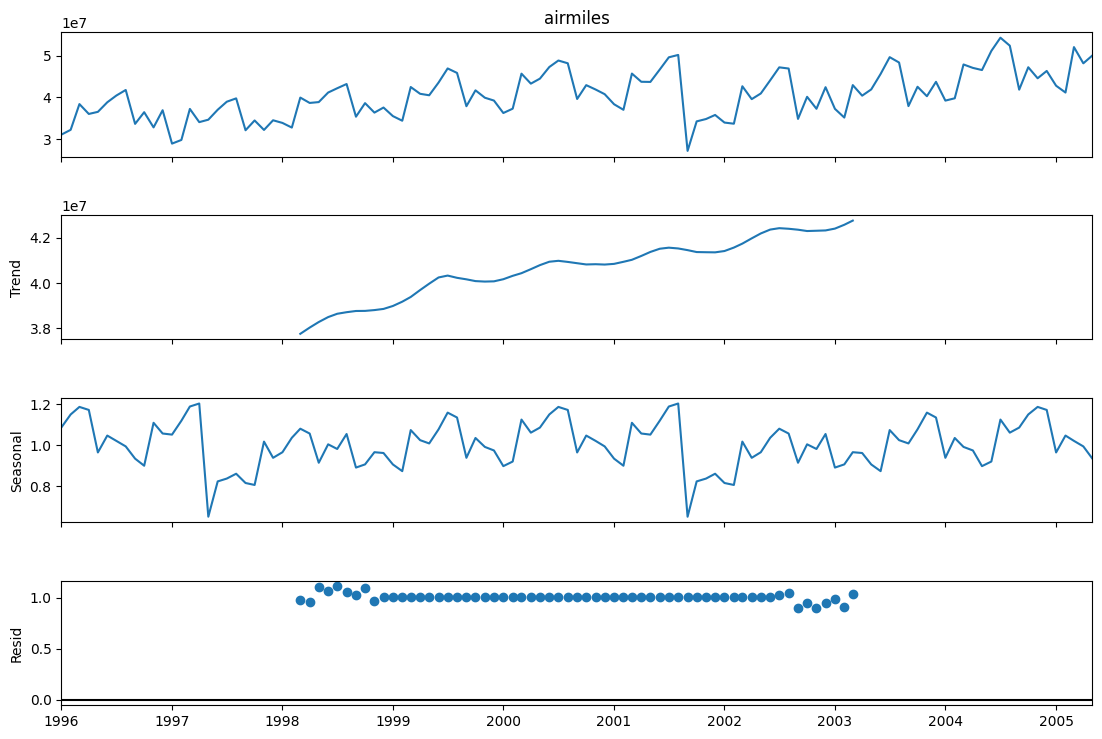

In [39]:
# Seasonal decomposition of 'airmiles'  (52 week period, model='multiplicative')
result = seasonal_decompose(df['airmiles'], model='multiplicative', period=52)
fig = result.plot()
fig.set_figheight(8)
fig.set_figwidth(12)
plt.show()

# Auto-Correlation Function (ACF)

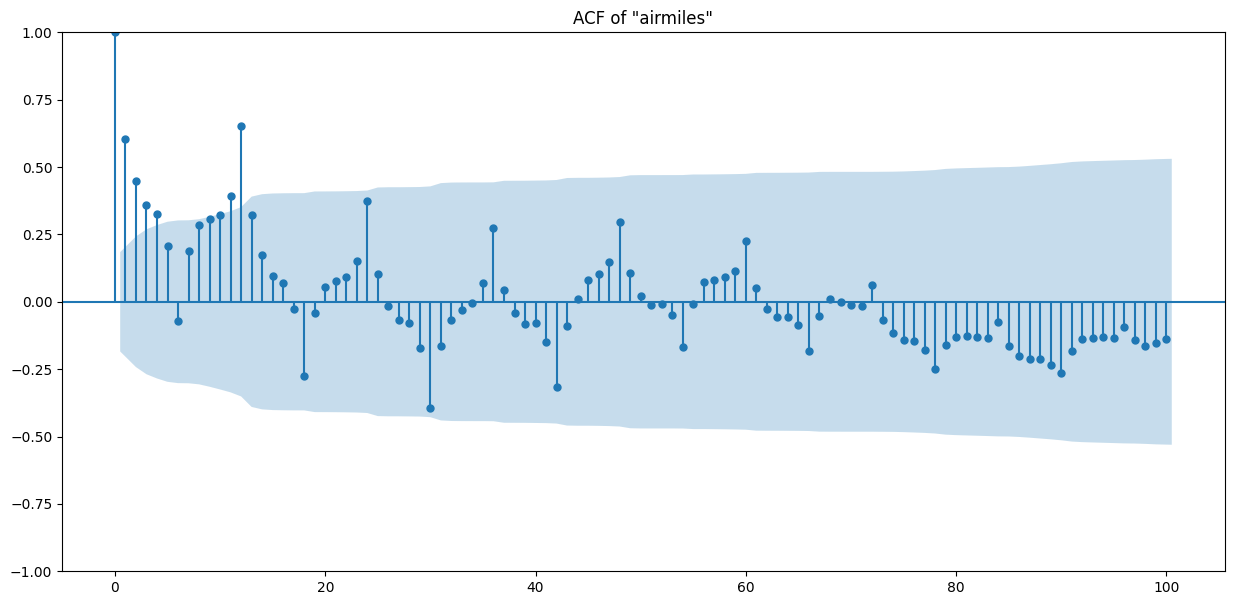

In [40]:
# Plot the ACF for the 'airmiles' data
fig, ax = plt.subplots(figsize=(15,7))
plot_acf(df['airmiles'], lags=100, ax=ax)
plt.title('ACF of "airmiles"')
plt.show()

# Partial Auto-Correlation (PACF)

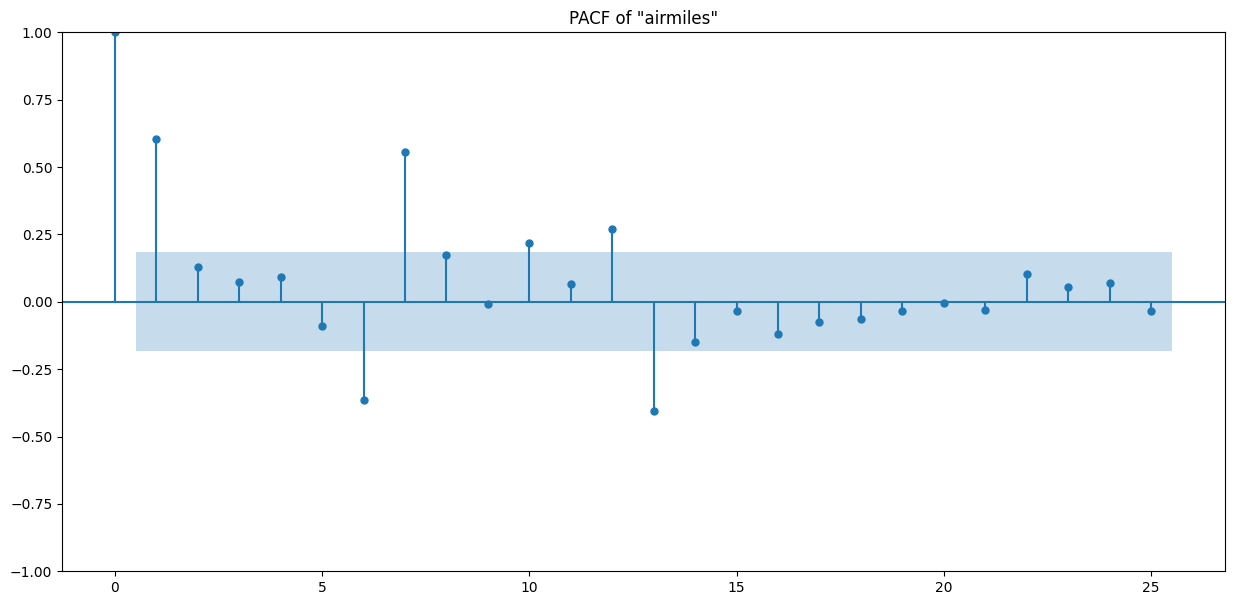

In [41]:
# PACF 'airmiles'
fig, ax = plt.subplots(figsize=(15,7))
plot_pacf(df['airmiles'], lags=25, ax=ax)
plt.title('PACF of "airmiles"')
plt.show()

# Print the frequency of time series

In [42]:
df.index

DatetimeIndex(['1996-01-01', '1996-02-01', '1996-03-01', '1996-04-01',
               '1996-05-01', '1996-06-01', '1996-07-01', '1996-08-01',
               '1996-09-01', '1996-10-01',
               ...
               '2004-08-01', '2004-09-01', '2004-10-01', '2004-11-01',
               '2004-12-01', '2005-01-01', '2005-02-01', '2005-03-01',
               '2005-04-01', '2005-05-01'],
              dtype='datetime64[ns]', name='Date', length=113, freq='MS')

# Goal: predict the number of airmiles over the next 6 time periods (i.e. months)

1. Split data into training and test datasets.

In [69]:
periods = 12
train = df[:-periods].airmiles
test = df[-periods:].airmiles

In [70]:
train.tail()

,airmiles
Date,
2004-01-01,39180114
2004-02-01,39736435
2004-03-01,47876012
2004-04-01,47050439
2004-05-01,46534130


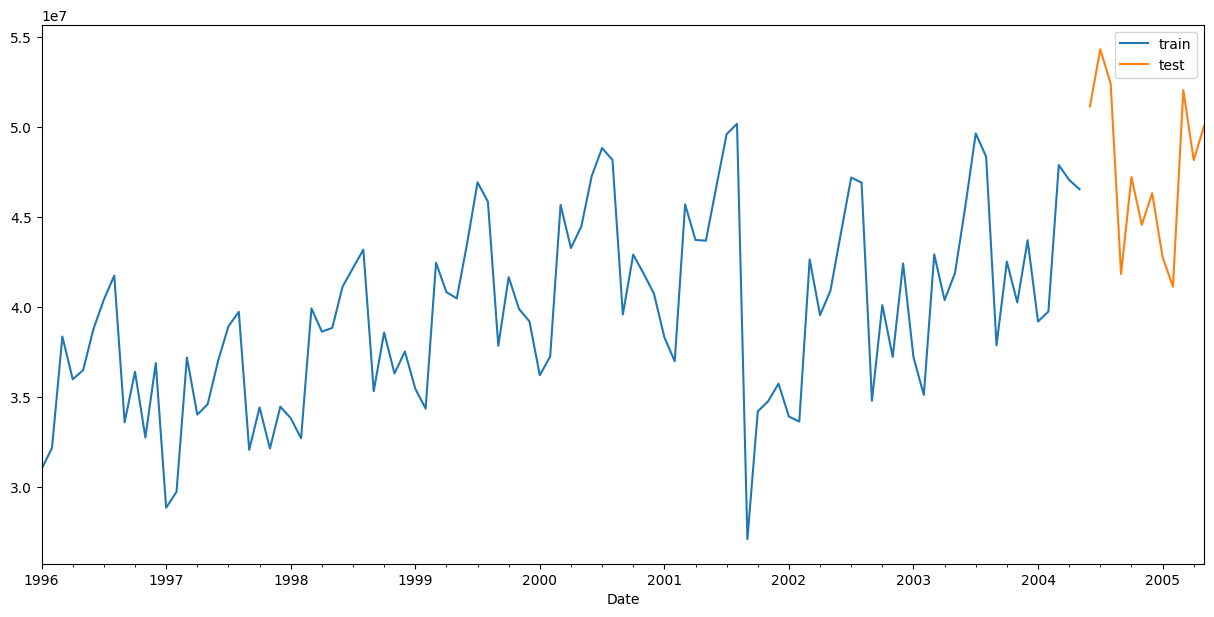

In [71]:
train.plot(figsize=(15,7))
test.plot(figsize=(15,7))
plt.legend(['train', 'test'])
plt.show()

# Apply Simple Exponential Smoothing to the train dataset

In [72]:
# Apply SES to train dataset
ses_model = SimpleExpSmoothing(train).fit()
print(ses_model.summary())

                        SimpleExpSmoothing Model Results                        
Dep. Variable:               airmiles   No. Observations:                    101
Model:             SimpleExpSmoothing   SSE                 1954450158675124.250
Optimized:                       True   AIC                             3093.970
Trend:                           None   BIC                             3099.200
Seasonal:                        None   AICC                            3094.387
Seasonal Periods:                None   Date:                   Fri, 11 Jul 2025
Box-Cox:                        False   Time:                           00:33:55
Box-Cox Coeff.:                  None                                           
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.5345349                alpha                 True
initial_level             3.0983e+

In [73]:
# Generate predictions
ses_pred = ses_model.predict(start=test.index[0], end=test.index[-1])
ses_pred

,0
2004-06-01,4.618040e+07
2004-07-01,4.618040e+07
2004-08-01,4.618040e+07
2004-09-01,4.618040e+07
2004-10-01,4.618040e+07
2004-11-01,4.618040e+07
2004-12-01,4.618040e+07
2005-01-01,4.618040e+07
2005-02-01,4.618040e+07
2005-03-01,4.618040e+07


Plot train, test and predictions....it's terrible!

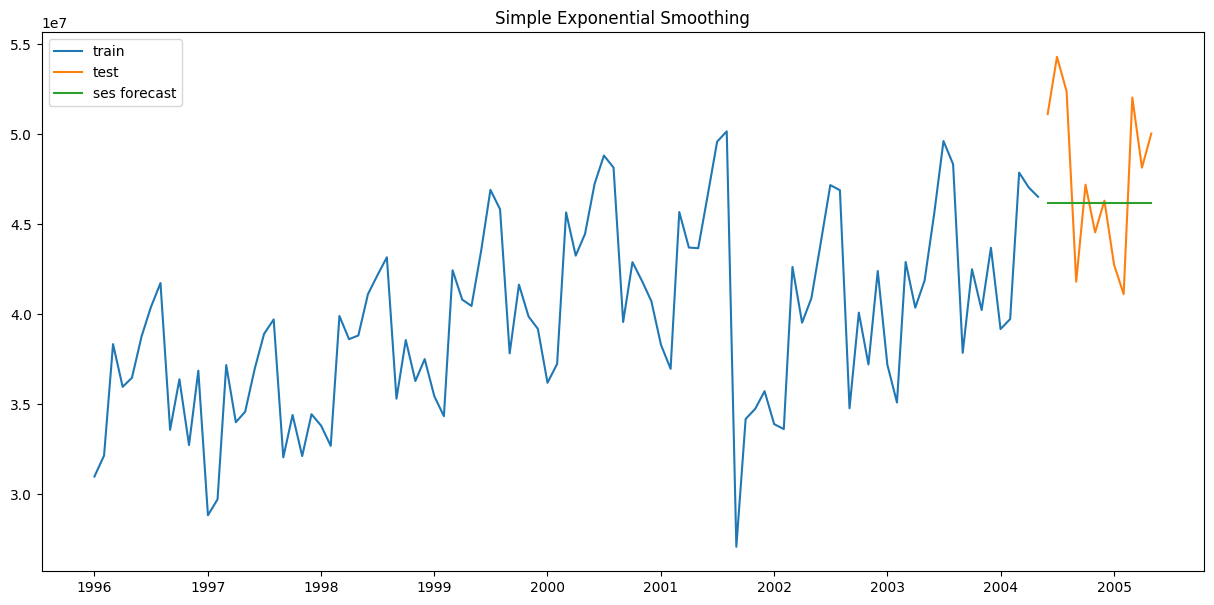

In [74]:
plt.figure(figsize=(15,7))
plt.plot(train, label='train')
plt.plot(test, label='test')
plt.plot(ses_pred, label='ses forecast')
plt.title('Simple Exponential Smoothing')
plt.legend()
plt.show()

# Double Exponential Smoothing

In [75]:
# Build double exponential smoothing model

des_model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12).fit()
print(des_model.summary())

                        ExponentialSmoothing Model Results                       
Dep. Variable:                 airmiles   No. Observations:                   101
Model:             ExponentialSmoothing   SSE                 365624025475434.625
Optimized:                         True   AIC                            2952.668
Trend:                         Additive   BIC                            2994.510
Seasonal:                      Additive   AICC                           2961.010
Seasonal Periods:                    12   Date:                  Fri, 11 Jul 2025
Box-Cox:                          False   Time:                          00:33:56
Box-Cox Coeff.:                    None                                          
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.5353571                alpha                 True
smoothing_trend 

In [76]:
# Generate predictions
des_pred = des_model.predict(start=test.index[0], end=test.index[-1])

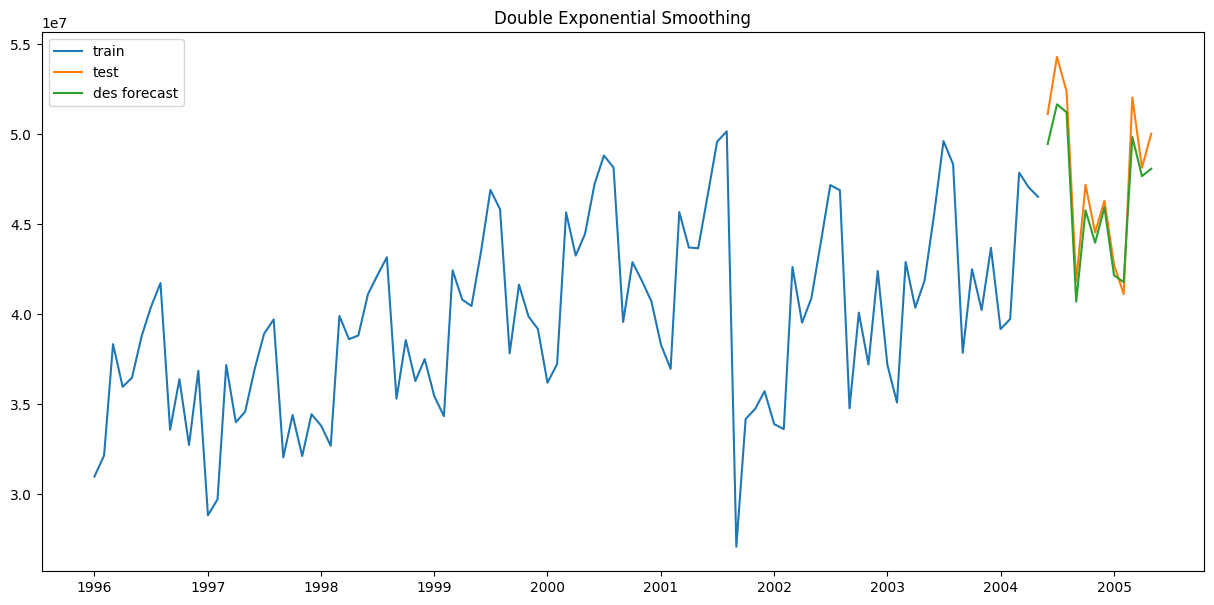

In [77]:
plt.figure(figsize=(15,7))
plt.plot(train, label='train')
plt.plot(test, label='test')
plt.plot(des_pred, label='des forecast')
plt.title('Double Exponential Smoothing')
plt.legend()
plt.show()

# Triple Exponential Smoothing - Holt Winters


In [78]:
# Build triple exponential smoothing model

tes_model = ExponentialSmoothing(train, trend='add', seasonal='mul', seasonal_periods=12).fit()
print(tes_model.summary())

                        ExponentialSmoothing Model Results                       
Dep. Variable:                 airmiles   No. Observations:                   101
Model:             ExponentialSmoothing   SSE                 323904774657257.250
Optimized:                         True   AIC                            2940.431
Trend:                         Additive   BIC                            2982.273
Seasonal:                Multiplicative   AICC                           2948.773
Seasonal Periods:                    12   Date:                  Fri, 11 Jul 2025
Box-Cox:                          False   Time:                          00:33:56
Box-Cox Coeff.:                    None                                          
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.5353571                alpha                 True
smoothing_trend 

In [79]:
# Generate predictions
tes_pred = tes_model.predict(start=test.index[0], end=test.index[-1])

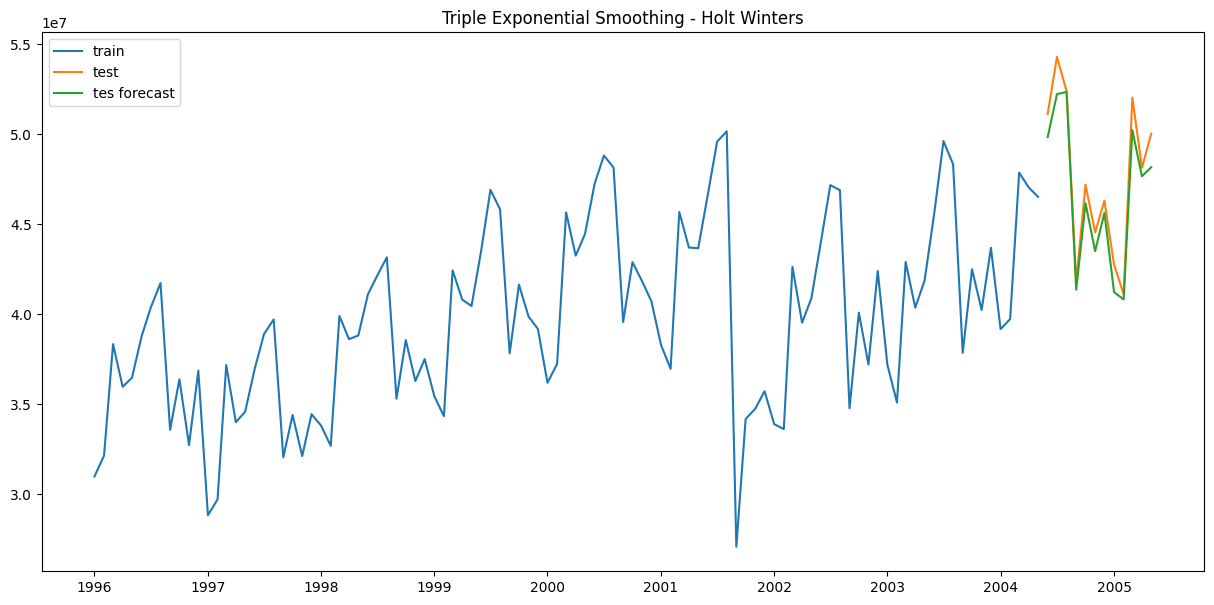

In [80]:
plt.figure(figsize=(15,7))
plt.plot(train, label='train')
plt.plot(test, label='test')
plt.plot(tes_pred, label='tes forecast')
plt.title('Triple Exponential Smoothing - Holt Winters')
plt.legend()
plt.show()

# Let's calculate some metrics on the model predictions...

In [81]:
# MAPE
mape_tes = np.mean(np.abs(test - tes_pred) / test) * 100
mape_des = np.mean(np.abs(test - des_pred) / test) * 100
mape_ses = np.mean(np.abs(test - ses_pred) / test) * 100
print(f'MAPE for Triple Exponential Smoothing - Holt Winters: {mape_tes:.2f}%')
print(f'MAPE for Double Exponential Smoothing: {mape_des:.2f}%')
print(f'MAPE for Simple Exponential Smoothing: {mape_ses:.2f}%')

MAPE for Triple Exponential Smoothing - Holt Winters: 2.16%
MAPE for Double Exponential Smoothing: 2.52%
MAPE for Simple Exponential Smoothing: 8.04%


In [82]:
# MAE

mae_tes = mean_absolute_error(test, tes_pred)
mae_des = mean_absolute_error(test, des_pred)
mae_ses = mean_absolute_error(test, ses_pred)
print(f'MAE for Triple Exponential Smoothing - Holt Winters: {mae_tes:.2f}')
print(f'MAE for Double Exponential Smoothing: {mae_des:.2f}')
print(f'MAE for Simple Exponential Smoothing: {mae_ses:.2f}')

MAE for Triple Exponential Smoothing - Holt Winters: 1046933.53
MAE for Double Exponential Smoothing: 1235752.70
MAE for Simple Exponential Smoothing: 3887220.25


In [83]:
# RMSE

rmse_tes = root_mean_squared_error(test, tes_pred)
rmse_des = root_mean_squared_error(test, des_pred)
rmse_ses = root_mean_squared_error(test, ses_pred)
print(f'RMSE for Triple Exponential Smoothing - Holt Winters: {rmse_tes:.2f}')
print(f'RMSE for Double Exponential Smoothing: {rmse_des:.2f}')
print(f'RMSE for Simple Exponential Smoothing: {rmse_ses:.2f}')

RMSE for Triple Exponential Smoothing - Holt Winters: 1230641.26
RMSE for Double Exponential Smoothing: 1428832.83
RMSE for Simple Exponential Smoothing: 4497504.25


In [84]:
# Let's functionalize the model assessment

def model_assess(train, test, pred, chart_title=None):
  plt.figure(figsize=(15,7))
  plt.plot(train, label='train')
  plt.plot(test, label='test')
  plt.plot(pred, label='forecast')
  plt.show()

  mape = np.mean(np.abs(test - pred) / test) * 100
  mae = mean_absolute_error(test, pred)
  rmse = root_mean_squared_error(test, pred)
  print(f'\nMAPE: {mape:.2f}%')
  print(f'MAE: {mae:.2f}')
  print(f'RMSE: {rmse:.2f}\n\n')
  return

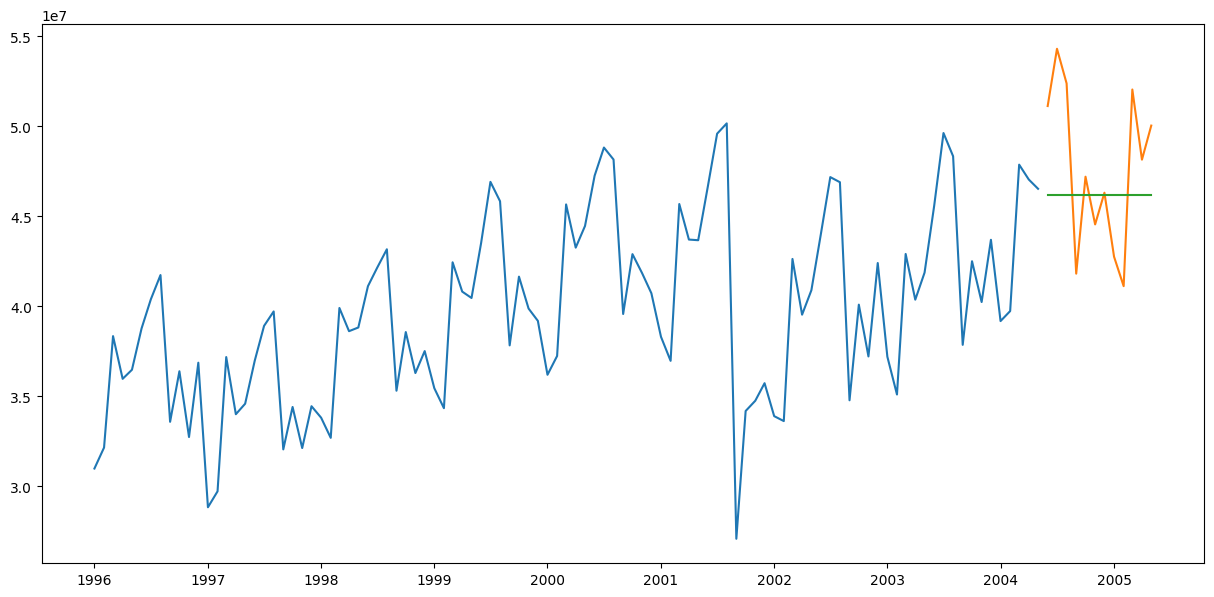


MAPE: 8.04%
MAE: 3887220.25
RMSE: 4497504.25




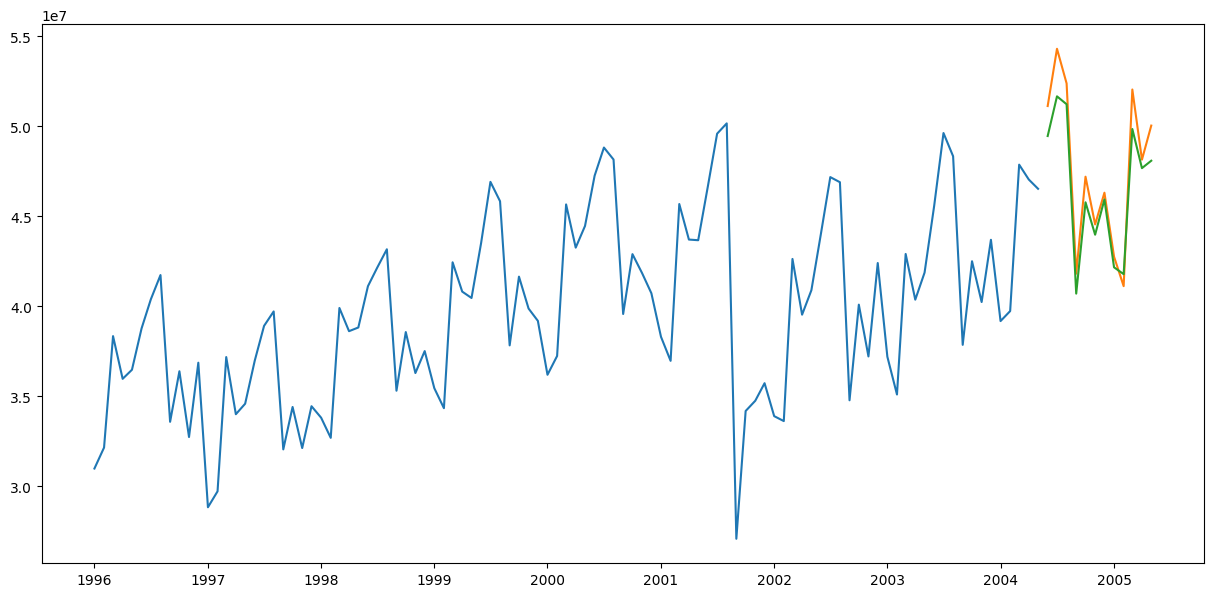


MAPE: 2.52%
MAE: 1235752.70
RMSE: 1428832.83




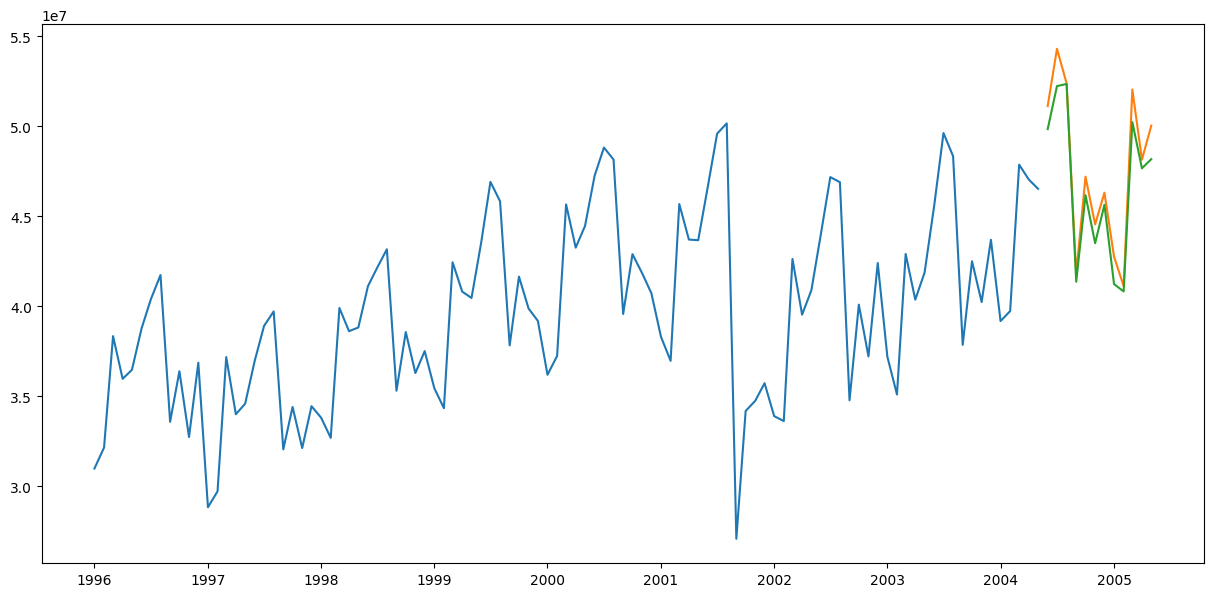


MAPE: 2.16%
MAE: 1046933.53
RMSE: 1230641.26




(None, None, None)

In [85]:
model_assess(train, test, ses_pred, 'Simple Exponential Smoothing'), model_assess(train, test, des_pred, 'Double Exponential Smoothing'), model_assess(train, test, tes_pred, 'Triple Exponential Smoothing - Holt Winters')

Train the model with the **complete** complaint dataset.

# Make future predictions using the model

In [86]:
# Explore the data

X = df.airmiles
X.head()

,airmiles
Date,
1996-01-01,30983174
1996-02-01,32147663
1996-03-01,38342975
1996-04-01,35969113
1996-05-01,36474391


In [87]:
# Train the model
tes_model = ExponentialSmoothing(X, trend='add', seasonal='mul', seasonal_periods=12).fit()
print(tes_model.summary())

                        ExponentialSmoothing Model Results                       
Dep. Variable:                 airmiles   No. Observations:                   113
Model:             ExponentialSmoothing   SSE                 333234976992115.625
Optimized:                         True   AIC                            3276.510
Trend:                         Additive   BIC                            3320.149
Seasonal:                Multiplicative   AICC                           3283.787
Seasonal Periods:                    12   Date:                  Fri, 11 Jul 2025
Box-Cox:                          False   Time:                          00:33:57
Box-Cox Coeff.:                    None                                          
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.5353571                alpha                 True
smoothing_trend 

In [91]:
# Make predictions

forecast = tes_model.forecast(steps=periods)
forecast

,0
2005-06-01,5.312494e+07
2005-07-01,5.577188e+07
2005-08-01,5.548414e+07
2005-09-01,4.362999e+07
2005-10-01,4.907124e+07
2005-11-01,4.638544e+07
2005-12-01,4.864741e+07
2006-01-01,4.407734e+07
2006-02-01,4.343077e+07
2006-03-01,5.364640e+07


In [92]:
# Plot the training data and the forecast

def plot_future_predictions(X,forecast,chart_title=None):
  plt.figure(figsize=(15,7))
  plt.plot(X, label='train')
  plt.plot(forecast, label='forecast')
  plt.title('Triple Exponential Smoothing - Holt Winters')
  plt.legend()
  plt.show()

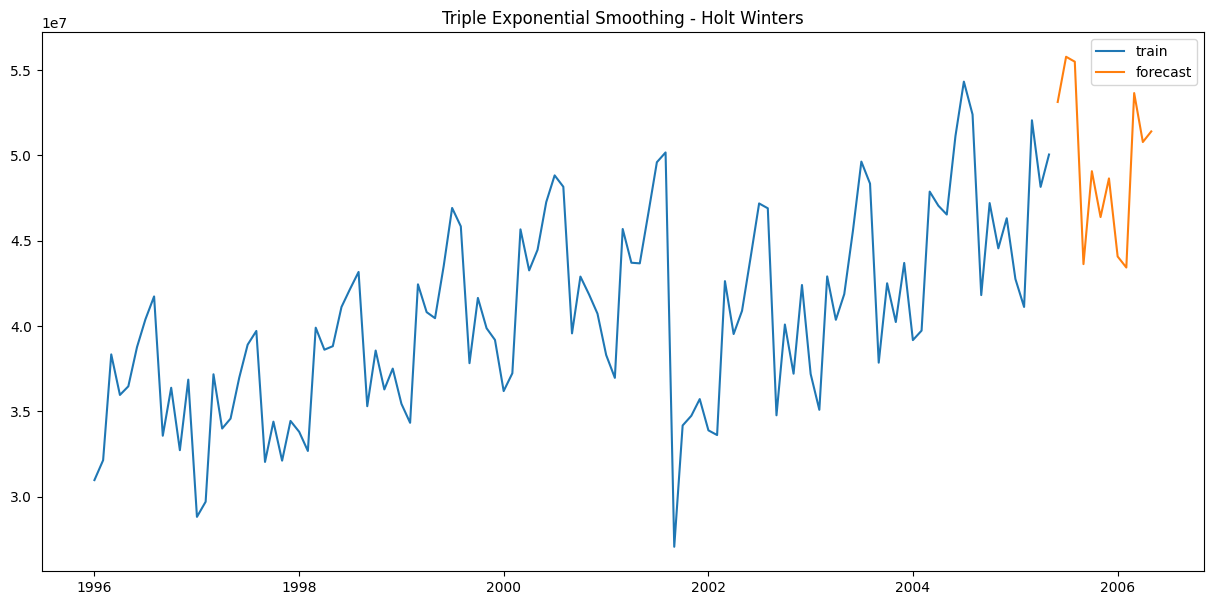

In [93]:
plot_future_predictions(X,forecast)